# EDA + Data Validation - Corneal Ulcer Segmentation (SUSTech-SYSU)

This notebook validates the dataset split and performs the key EDA checks needed **before training** a segmentation model.

**Inputs**
- `dataset_index.csv` (created by your split script)
- Folders: `rawImages/`, `ulcerLabels/` (optional: `corneaLabels/`)

**Outputs**
- Summary tables + plots
- Visual sanity checks (overlays)
- Mask statistics (binarity, size match, ulcer area distribution)


## 0) Setup




In [ ]:
# =============
# Config
# =============
from pathlib import Path

# Option A (recommended): set DATA_ROOT to the dataset folder
# Example (Colab): DATA_ROOT = Path("/content/drive/MyDrive/your_dataset")
# Example (Local): DATA_ROOT = Path("/Users/you/path/to/dataset")
DATA_ROOT = Path("../data")  # <-- change if needed

# If your CSV is not inside DATA_ROOT, set an explicit path:
INDEX_CSV = DATA_ROOT / "outputs" / "dataset_index.csv"  # <-- change if needed

# Default folder names 
RAW_DIR   = DATA_ROOT / "rawImages"
MASK_DIR  = DATA_ROOT / "ulcerLabels"
CORNEA_DIR = DATA_ROOT / "corneaLabels"  # optional

# Random seed for reproducibility in sampling visuals
SEED = 42


## 1) Load `dataset_index.csv` and inspect

In [9]:
import pandas as pd
import numpy as np

assert INDEX_CSV.exists(), f"dataset_index.csv not found: {INDEX_CSV}"

df = pd.read_csv(INDEX_CSV)
df.head()


,id,category,type,grade,split
0,359,1,4,4,train
1,360,1,4,4,test
2,361,1,4,4,train
3,362,1,4,4,train
4,363,1,2,4,test


## 2) Normalize IDs & Resolve Paths

Extract numeric ID $n$ from each entry, then build paths:

$$\text{image\_path} = \texttt{rawImages/} \, n \texttt{.png}, \quad \text{mask\_path} = \texttt{ulcerLabels/} \, n \texttt{.png}$$

In [20]:
import re

def _to_int_id(x):
    m = re.search(r"(\d+)", str(x))
    return int(m.group(1)) if m else None

df["id_png"] = df["id_int"].astype(int).astype(str) + ".png"
df["id_jpg"] = df["id_int"].astype(int).astype(str) + ".jpg"
df["image_path_resolved"] = df["id_jpg"].apply(lambda fn: RAW_DIR / fn)  
df["mask_path_resolved"]  = df["id_png"].apply(lambda fn: MASK_DIR / fn)  

df.head()


,id,category,type,grade,split,id_int,id_png,image_path_resolved,mask_path_resolved,id_jpg
0,359,1,4,4,train,359,359.png,../data/rawImages/359.jpg,../data/ulcerLabels/359.png,359.jpg
1,360,1,4,4,test,360,360.png,../data/rawImages/360.jpg,../data/ulcerLabels/360.png,360.jpg
2,361,1,4,4,train,361,361.png,../data/rawImages/361.jpg,../data/ulcerLabels/361.png,361.jpg
3,362,1,4,4,train,362,362.png,../data/rawImages/362.jpg,../data/ulcerLabels/362.png,362.jpg
4,363,1,2,4,test,363,363.png,../data/rawImages/363.jpg,../data/ulcerLabels/363.png,363.jpg


## 3) Split sanity checks

We verify:
- No overlap between train/val/test IDs
- Split sizes


In [21]:
splits = {s: set(df.loc[df["split"] == s, "id_int"].astype(int)) for s in df["split"].unique()}
splits

# Overlap check
names = sorted(splits.keys())
overlaps = []
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        inter = splits[a] & splits[b]
        overlaps.append((a, b, len(inter)))
overlaps


[('test', 'train', 0), ('test', 'val', 0), ('train', 'val', 0)]

In [22]:
# Split sizes
df["split"].value_counts().reset_index(name = "count")


,split,count
0,train,247
1,test,54
2,val,53


## 4) Metadata distribution per split (Category / Grade / Type)

If those columns exist in the CSV, we summarize them per split to detect bias.


In [23]:
def show_dist(col):
    if col not in df.columns:
        print(f"Column '{col}' not found in CSV - skipping.")
        return
    tab = pd.crosstab(df["split"], df[col], normalize="index") * 100
    display(tab.round(1))

for col in ["category", "grade", "type"]:
    show_dist(col)


category,1,2
split,,
test,70.4,29.6
train,75.3,24.7
val,73.6,26.4


grade,1,2,3,4
split,,,,
test,13.0,3.7,1.9,81.5
train,12.1,4.0,1.6,82.2
val,11.3,3.8,1.9,83.0


type,1,2,3,4
split,,,,
test,18.5,24.1,24.1,33.3
train,14.2,27.1,30.8,27.9
val,11.3,28.3,32.1,28.3


## 5) File existence checks

We validate that all files referenced by the index exist.


In [24]:
missing_img = df.loc[~df["image_path_resolved"].apply(lambda p: Path(p).exists()), ["id", "image_path_resolved"]]
missing_msk = df.loc[~df["mask_path_resolved"].apply(lambda p: Path(p).exists()), ["id", "mask_path_resolved"]]

print("Missing images:", len(missing_img))
display(missing_img.head(10))

print("Missing masks:", len(missing_msk))
display(missing_msk.head(10))

assert len(missing_img) == 0, "Some image files are missing. Fix paths/folders first."
assert len(missing_msk) == 0, "Some mask files are missing. Fix paths/folders first."


Missing images: 0


,id,image_path_resolved


Missing masks: 0


,id,mask_path_resolved


## 6) Image-mask shape checks + mask binarity

We check:
- Image and mask have the same width/height
- Masks are binary (typically {0,255} or {0,1})


In [36]:
from PIL import Image

def read_size(p: Path):
    with Image.open(p) as im:
        return im.size  # (W,H)

def read_mask_unique_values(p: Path, max_samples=200000):
    with Image.open(p) as im:
        arr = np.array(im)
  
    if arr.ndim == 3:
        arr = arr.max(axis=2)
    flat = arr.reshape(-1)
    if flat.size > max_samples:
        idx = np.random.default_rng(SEED).choice(flat.size, size=max_samples, replace=False)
        flat = flat[idx]
    return np.unique(flat)

# Sample for speed
rng = np.random.default_rng(SEED)
sample_idx = rng.choice(len(df), size= len(df), replace=False)
df_s = df.iloc[sample_idx].copy()

size_mismatch = []
non_binary = []

for _, row in df_s.iterrows():
    img_p = Path(row["image_path_resolved"])
    msk_p = Path(row["mask_path_resolved"])
    iw, ih = read_size(img_p)
    mw, mh = read_size(msk_p)
    if (iw, ih) != (mw, mh):
        size_mismatch.append((row["id"], (iw, ih), (mw, mh)))
    uniq = read_mask_unique_values(msk_p)
    # consider binary if unique set is subset of {0,1,255}
    allowed = {0, 1, 255}
    if not set(map(int, uniq.tolist())).issubset(allowed):
        non_binary.append((row["id"], uniq[:20]))

print("Checked samples:", len(df_s))
print("Size mismatches:", len(size_mismatch))
print("Non-binary masks:", len(non_binary))

if size_mismatch:
    display(pd.DataFrame(size_mismatch, columns=["id", "image_size_(W,H)", "mask_size_(W,H)"]).head(10))
if non_binary:
    display(pd.DataFrame(non_binary, columns=["id", "mask_unique_values_sample"]).head(10))


Checked samples: 354
Size mismatches: 0
Non-binary masks: 0


## 7) Visual sanity checks (overlay)

We randomly show examples per split:
- Raw image
- Mask
- Overlay (mask in red)

If something looks wrong, fix it before training.


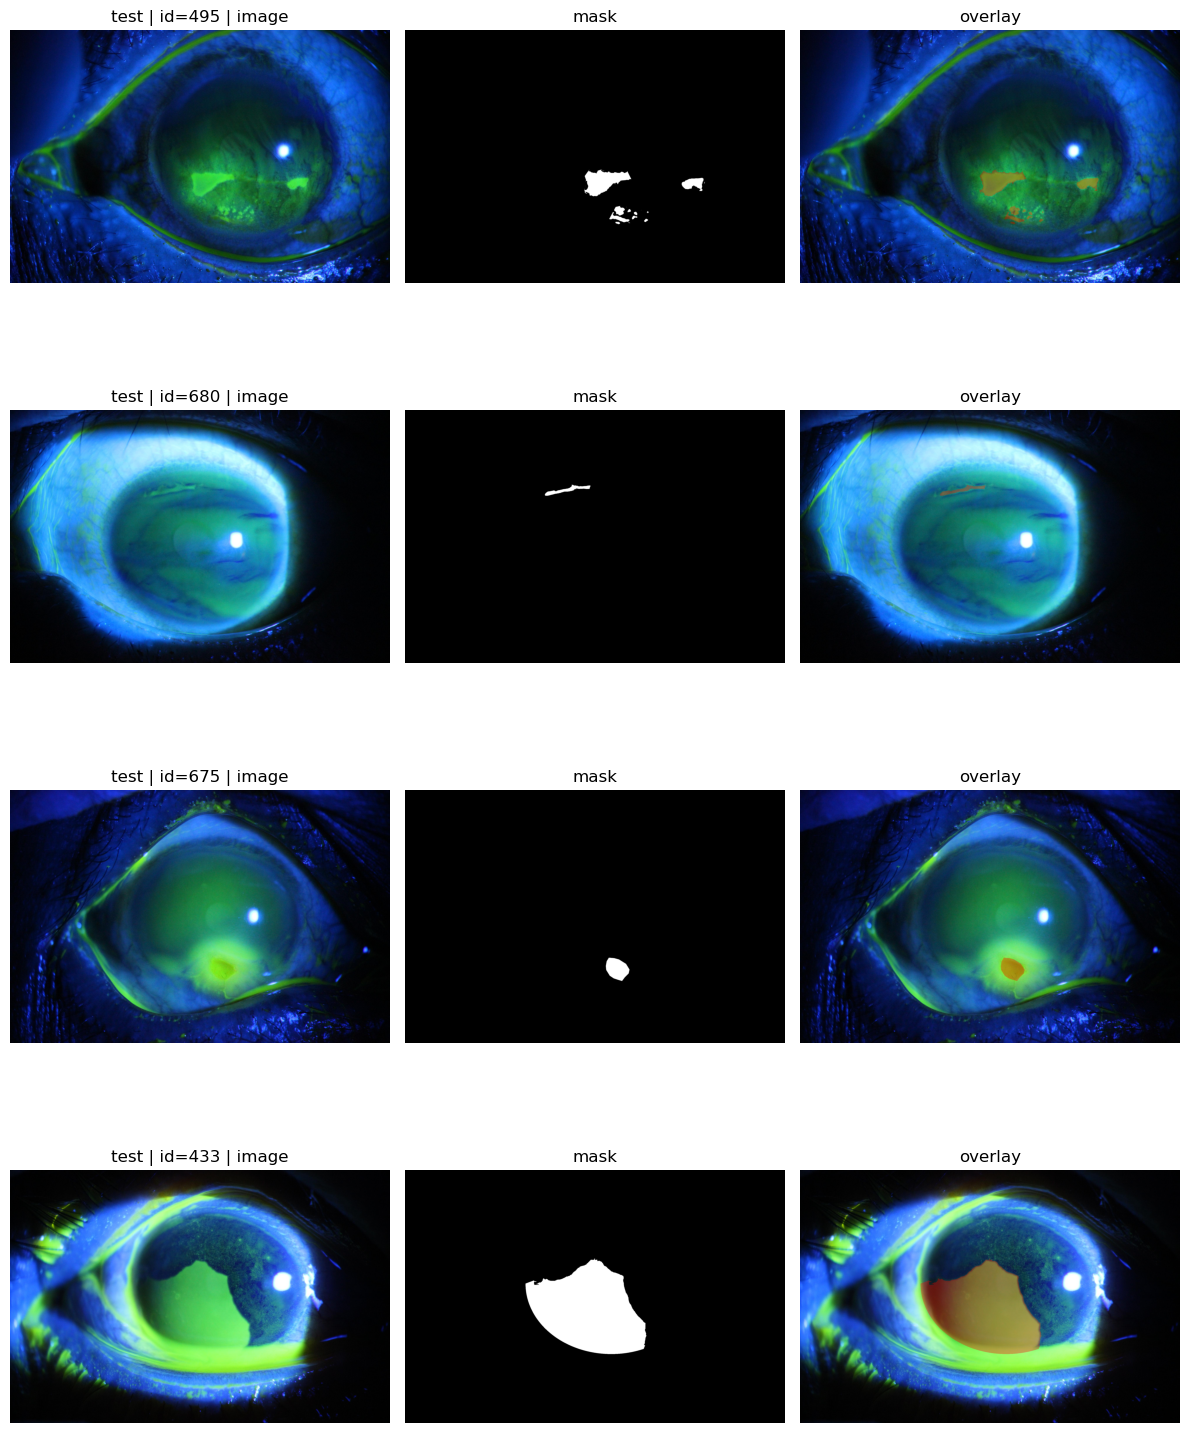

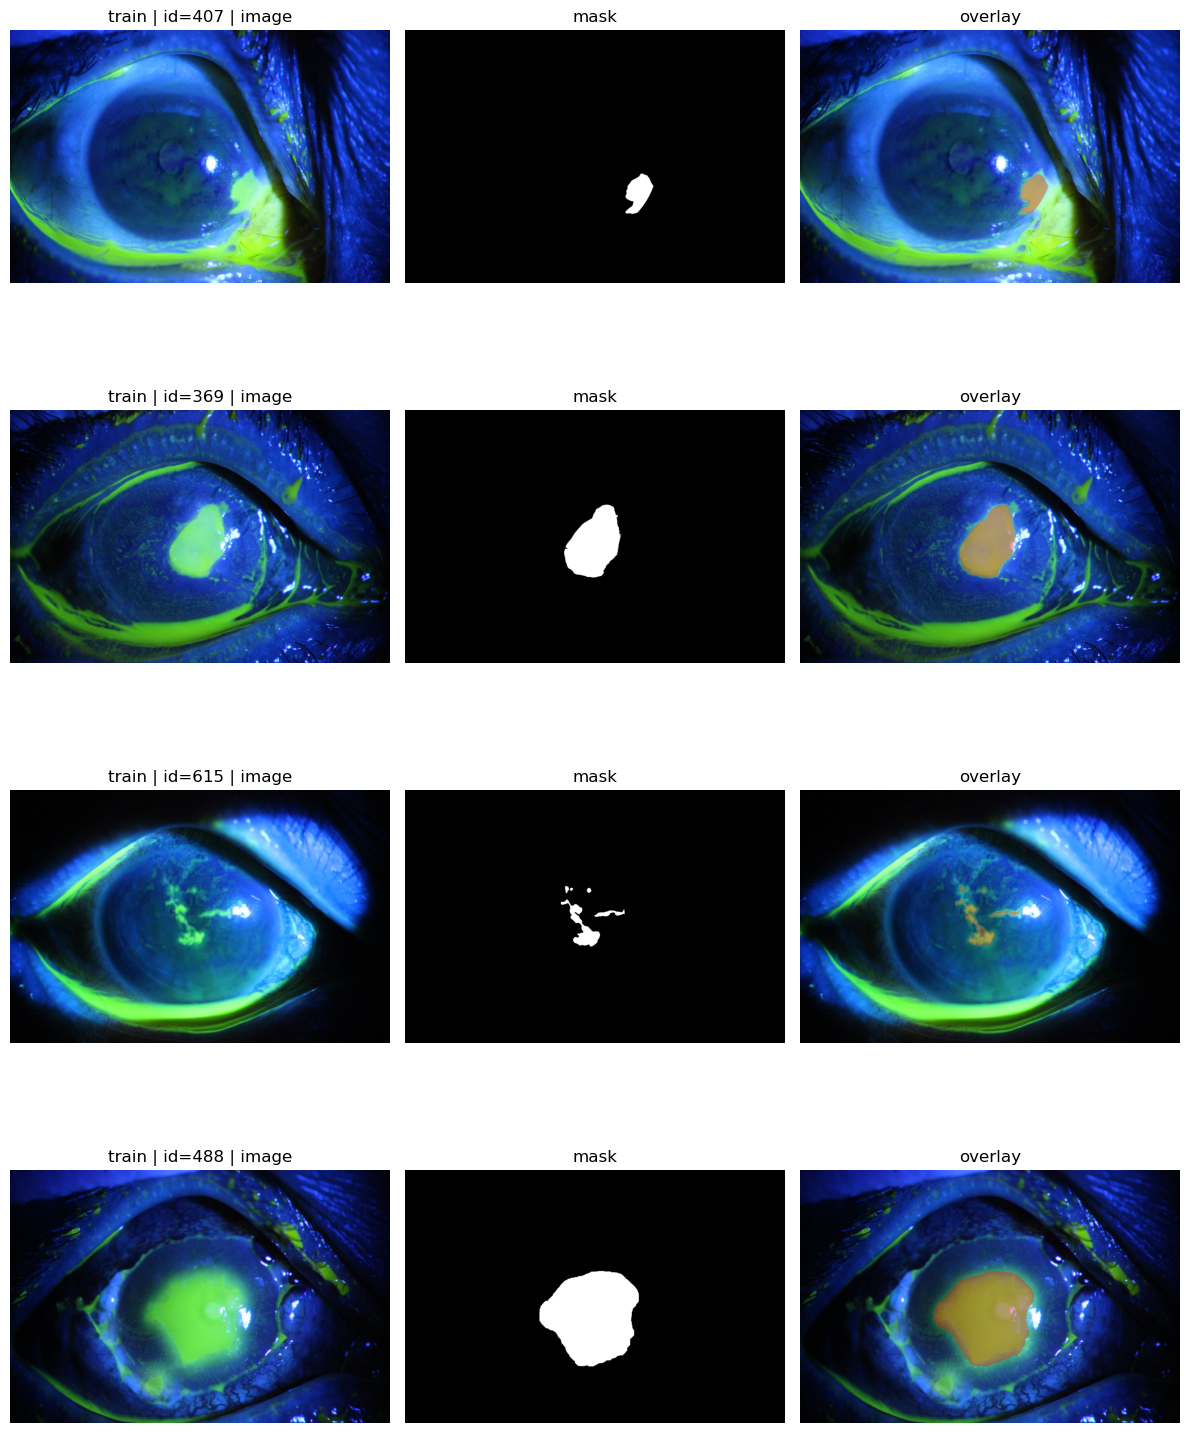

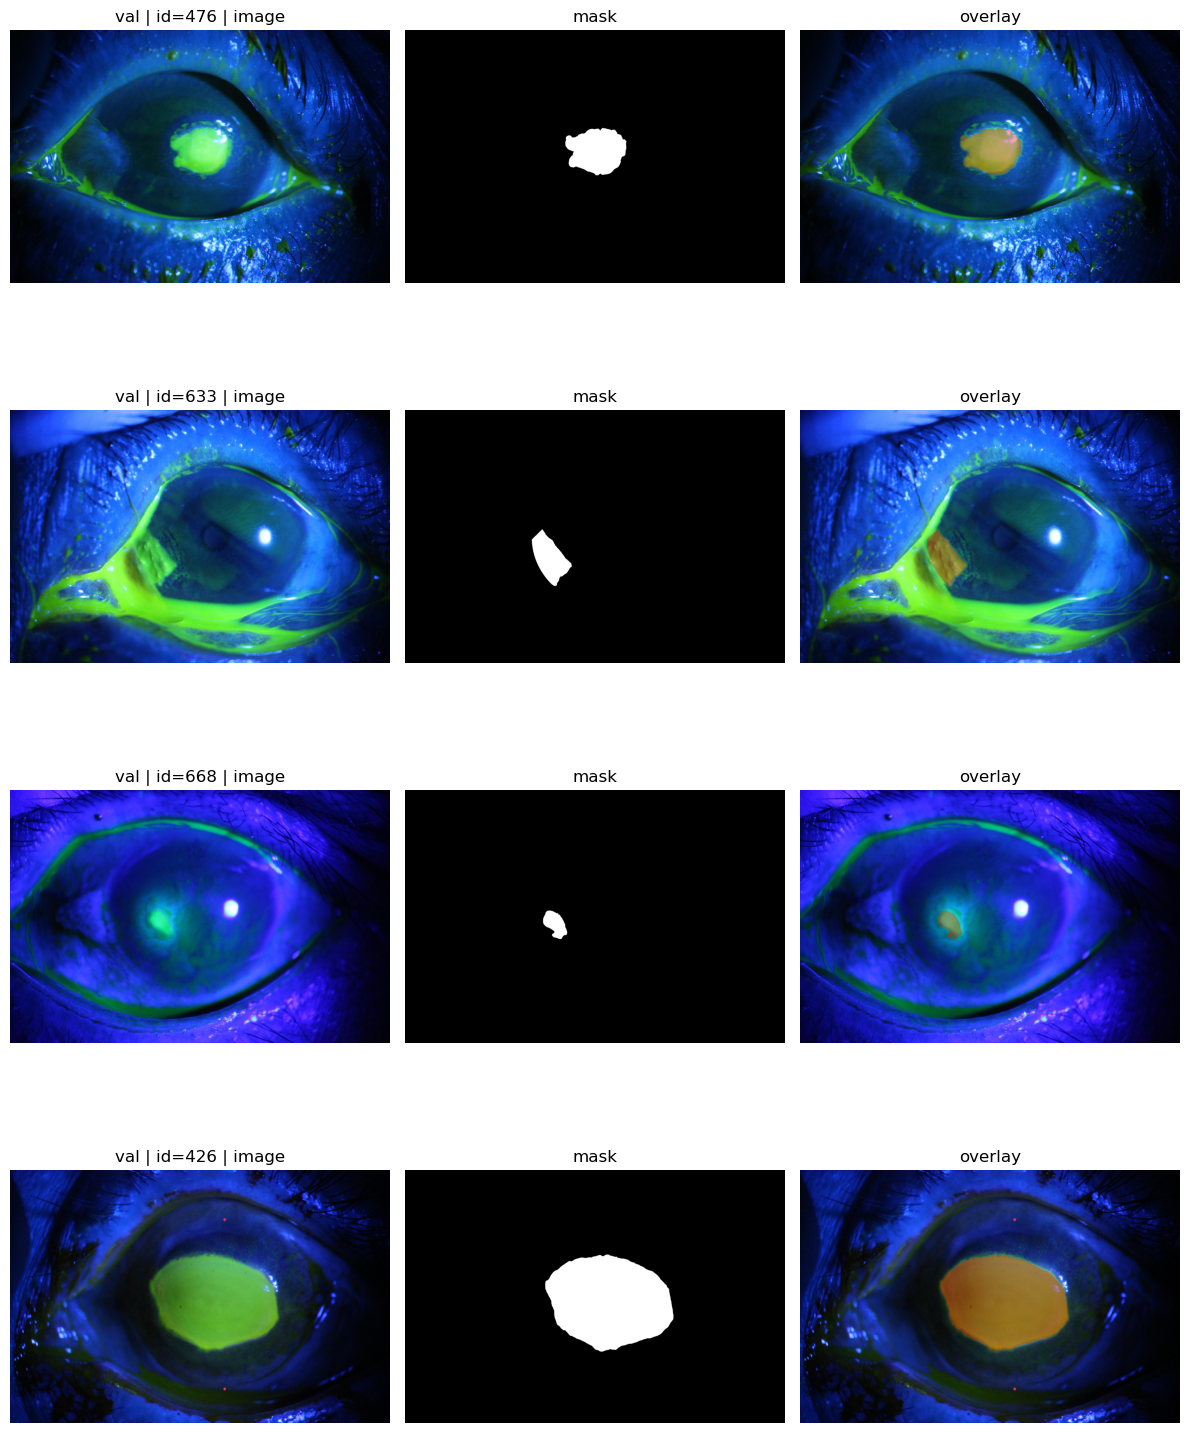

In [31]:
import matplotlib.pyplot as plt

def load_rgb(p: Path):
    with Image.open(p) as im:
        return np.array(im.convert("RGB"))

def load_mask01(p: Path, thr=127):
    with Image.open(p) as im:
        arr = np.array(im)
    if arr.ndim == 3:
        arr = arr.max(axis=2)
    # Convert to {0,1}
    return (arr < thr).astype(np.uint8)

def show_overlay(img, mask01, alpha=0.35):
    overlay = img.copy().astype(np.float32)
    red = np.zeros_like(overlay)
    red[..., 0] = 255
    m = mask01.astype(bool)
    overlay[m] = (1 - alpha) * overlay[m] + alpha * red[m]
    return overlay.astype(np.uint8)

def plot_examples(split, n=6):
    d = df[df["split"] == split].sample(n=min(n, (df["split"] == split).sum()), random_state=SEED)
    cols = 3
    rows = len(d)
    plt.figure(figsize=(12, 4 * rows))
    for i, (_, row) in enumerate(d.iterrows()):
        img = load_rgb(Path(row["image_path_resolved"]))
        m01 = load_mask01(Path(row["mask_path_resolved"]))
        ov = show_overlay(img, m01)

        # Image
        ax1 = plt.subplot(rows, cols, i*cols + 1)
        ax1.imshow(img)
        ax1.set_title(f"{split} | id={row['id_int']} | image")
        ax1.axis("off")

        # Mask
        ax2 = plt.subplot(rows, cols, i*cols + 2)
        ax2.imshow(m01, cmap="gray")
        ax2.set_title("mask")
        ax2.axis("off")

        # Overlay
        ax3 = plt.subplot(rows, cols, i*cols + 3)
        ax3.imshow(ov)
        ax3.set_title("overlay")
        ax3.axis("off")

    plt.tight_layout()
    plt.show()

for s in sorted(df["split"].unique()):
    plot_examples(s, n=4)


## 8) Ulcer area statistics (class imbalance)

We compute the fraction of positive pixels in each mask:
- Helps choose loss (Dice/BCE+Dice) and understand imbalance


In [32]:
def mask_pos_fraction(p: Path, thr=127):
    m01 = load_mask01(p, thr=thr)
    return float(m01.mean())

# Compute for all rows (may take time, but dataset is small)
fractions = []
for p in df["mask_path_resolved"]:
    fractions.append(mask_pos_fraction(Path(p)))

df["ulcer_pos_frac"] = fractions

df[["ulcer_pos_frac"]].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95,0.99])


,ulcer_pos_frac
count,354.000000
mean,0.032339
std,0.040036
min,0.000167
10%,0.002832
25%,0.006916
50%,0.018079
75%,0.039975
90%,0.083155
95%,0.120331


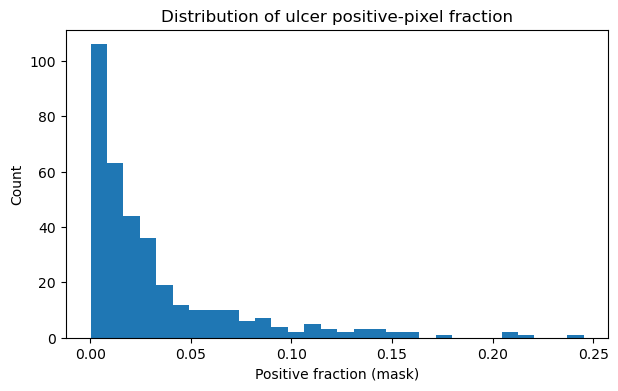

/var/folders/mw/qz5v9f6x61786w8mwbst5c100000gn/T/ipykernel_67671/2175010278.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df["split"].unique()))


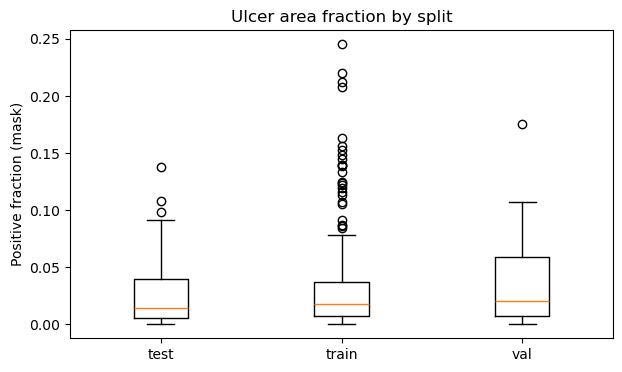

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(df["ulcer_pos_frac"].values, bins=30)
plt.title("Distribution of ulcer positive-pixel fraction")
plt.xlabel("Positive fraction (mask)")
plt.ylabel("Count")
plt.show()

# By split (boxplot)
plt.figure(figsize=(7,4))
data = [df.loc[df["split"]==s, "ulcer_pos_frac"].values for s in sorted(df["split"].unique())]
plt.boxplot(data, labels=sorted(df["split"].unique()))
plt.title("Ulcer area fraction by split")
plt.ylabel("Positive fraction (mask)")
plt.show()


## 9) Check for empty / nearly-empty masks

Empty masks can exist in some datasets. For ulcer segmentation, too many empty masks can affect training.


In [34]:
thr_empty = 0.0
thr_near_empty = 0.0005  # 0.05% pixels positive

empty = df[df["ulcer_pos_frac"] <= thr_empty]
near_empty = df[(df["ulcer_pos_frac"] > thr_empty) & (df["ulcer_pos_frac"] <= thr_near_empty)]

print("Empty masks:", len(empty))
print("Near-empty masks:", len(near_empty))

display(near_empty[["id_int","split","ulcer_pos_frac"]].head(20))


Empty masks: 0
Near-empty masks: 5


,id_int,split,ulcer_pos_frac
104,463,train,0.000464
188,547,train,0.000433
246,605,test,0.000480
249,608,train,0.000235
268,627,train,0.000167


## 10) Verify `corneaLabels/` coverage



In [35]:
from pathlib import Path

if CORNEA_DIR.exists():
    # resolve cornea mask path by same ID
    df["cornea_path"] = df["id_png"].apply(lambda fn: CORNEA_DIR / fn)
    missing_cornea = df.loc[~df["cornea_path"].apply(lambda p: Path(p).exists()), ["id_int","cornea_path"]]
    print("Cornea labels found:", int((df["cornea_path"].apply(lambda p: Path(p).exists())).sum()), "/", len(df))
    print("Missing cornea labels:", len(missing_cornea))
    display(missing_cornea.head(10))
else:
    print(f"CORNEA_DIR not found: {CORNEA_DIR} (skip)")


Cornea labels found: 354 / 354
Missing cornea labels: 0


,id_int,cornea_path


# Summary 

- **Samples:** 354 labeled images (with ulcer masks)  
- **Split:** train 247, val 53, test 54  
- **Leakage:** no overlap between splits (0)

- **Files:** missing images 0, missing masks 0  
- **Cornea masks:** 354/354 exist

- **Quality checks (all dataset):** size mismatches 0, non-binary masks 0, overlays look aligned

- **Class imbalance (ulcer is black => positive < 127):**
  - mean ulcer area fraction: **0.032**
  - median: **0.018**
  - max: **0.245**
  - empty masks: 0, near-empty: 5

- **Metadata:** category/grade/type distributions similar across splits (grade 4 dominates ~82%)
